In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from tqdm import tqdm

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
input_size = 28
sequence_length = 28
batch_size = 64
num_epochs = 10
learning_rate = 0.001
num_classes = 10
num_layers = 2
hidden_size = 256

In [30]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True) ## This means in the shaper of the data provided, batch_size comes first then the other dimensions
        self.fc = nn.Linear(hidden_size*sequence_length, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(device)

        out, h1 = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [31]:
train_dataset = datasets.MNIST(root = 'datasets/', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = 'datasets/', train = False, transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

In [32]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [33]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [37]:
summary(model, (28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 28, 256], [-1, 2, 256]]               0
            Linear-2                   [-1, 10]          71,690
Total params: 71,690
Trainable params: 71,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 28.00
Params size (MB): 0.27
Estimated Total Size (MB): 28.28
----------------------------------------------------------------


In [43]:
train_acc = []
test_acc = []

for epoch in tqdm(range(num_epochs)):
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device = device).squeeze(1)
        targets = targets.to(device = device)

        scores = model(data)
        loss_value = loss_criterion(scores, targets)

        optimizer.zero_grad()
        loss_value.backward()

        optimizer.step()
    print(f"At epoch {epoch+1}/{num_epochs}:-")

    num_correct = num_samples = 0
    for batch_idx, (data, targets) in enumerate(train_loader):

        data = data.to(device = device).squeeze(1)
        targets = targets.to(device = device)

        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Train accuracy = {num_correct/num_samples*100}")
    train_acc.append(num_correct/num_samples*100)

    num_correct = num_samples = 0
    for batch_idx, (data, targets) in enumerate(test_loader):

        data = data.to(device = device).squeeze(1)
        targets = targets.to(device = device)

        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(f"Test accracy = {num_correct/num_samples*100}")
    test_acc.append(num_correct/num_samples*100)

  0%|          | 0/10 [00:00<?, ?it/s]

At epoch 1/10:-
Train accuracy = 97.76333618164062


 10%|█         | 1/10 [00:12<01:48, 12.11s/it]

Test accracy = 97.38999938964844
At epoch 2/10:-
Train accuracy = 98.38333892822266


 20%|██        | 2/10 [00:25<01:40, 12.60s/it]

Test accracy = 97.78999328613281
At epoch 3/10:-
Train accuracy = 98.10333251953125


 30%|███       | 3/10 [00:37<01:26, 12.38s/it]

Test accracy = 97.19999694824219
At epoch 4/10:-
Train accuracy = 89.14167022705078


 40%|████      | 4/10 [00:48<01:11, 11.91s/it]

Test accracy = 89.76000213623047
At epoch 5/10:-
Train accuracy = 96.36833953857422


 50%|█████     | 5/10 [00:59<00:58, 11.71s/it]

Test accracy = 95.48999786376953
At epoch 6/10:-
Train accuracy = 98.6500015258789


 60%|██████    | 6/10 [01:10<00:45, 11.40s/it]

Test accracy = 98.25999450683594
At epoch 7/10:-
Train accuracy = 98.4816665649414


 70%|███████   | 7/10 [01:20<00:33, 11.09s/it]

Test accracy = 97.88999938964844
At epoch 8/10:-
Train accuracy = 98.04500579833984


 80%|████████  | 8/10 [01:31<00:21, 10.93s/it]

Test accracy = 97.39999389648438
At epoch 9/10:-
Train accuracy = 98.4050064086914


 90%|█████████ | 9/10 [01:50<00:13, 13.51s/it]

Test accracy = 97.75999450683594
At epoch 10/10:-
Train accuracy = 97.95166778564453


100%|██████████| 10/10 [02:22<00:00, 14.24s/it]

Test accracy = 97.12999725341797


In [44]:
tr_acc = torch.tensor(train_acc, device = 'cpu').numpy()
te_acc = torch.tensor(test_acc, device = 'cpu').numpy()

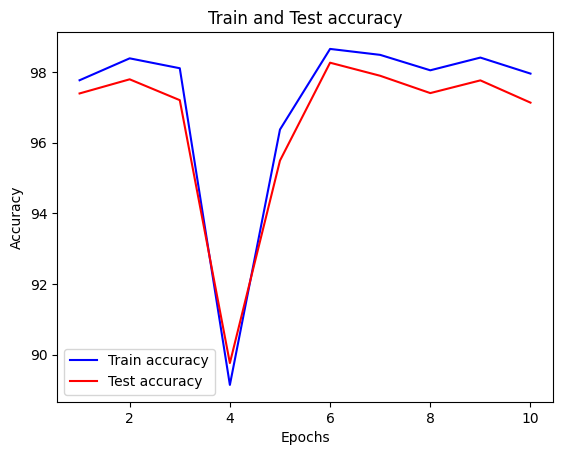

In [45]:
epchs = np.arange(num_epochs)+1

plt.plot(epchs, tr_acc, label = "Train accuracy", color = "blue")
plt.plot(epchs, te_acc, label = "Test accuracy", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train and Test accuracy")
plt.show()